Episode 10000/10000.

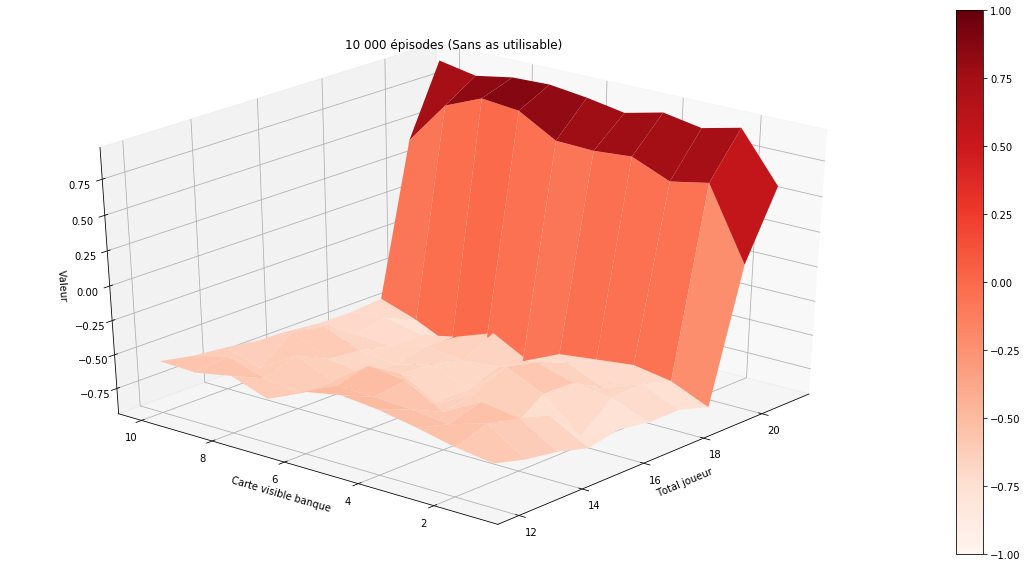

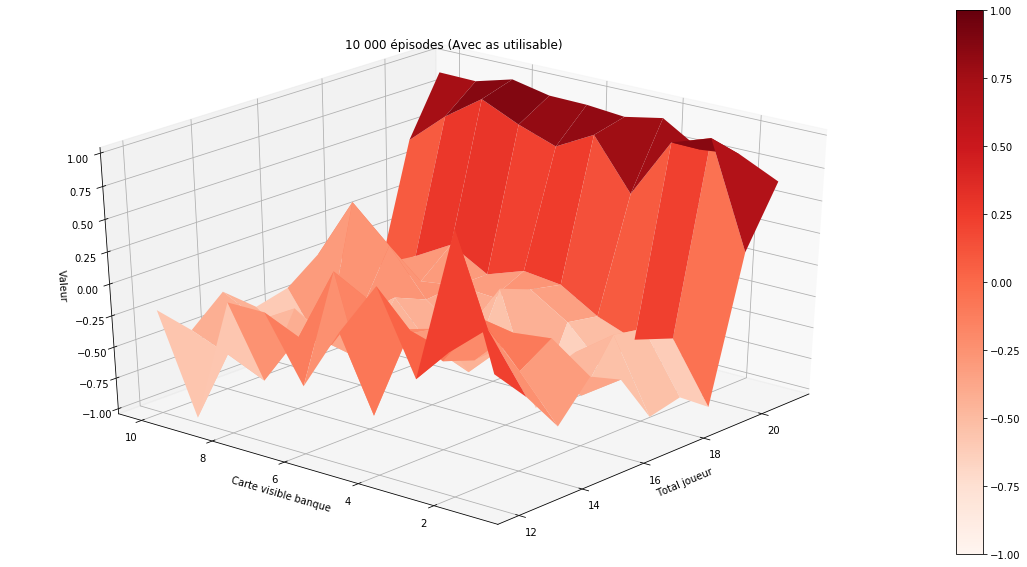

Episode 500000/500000.

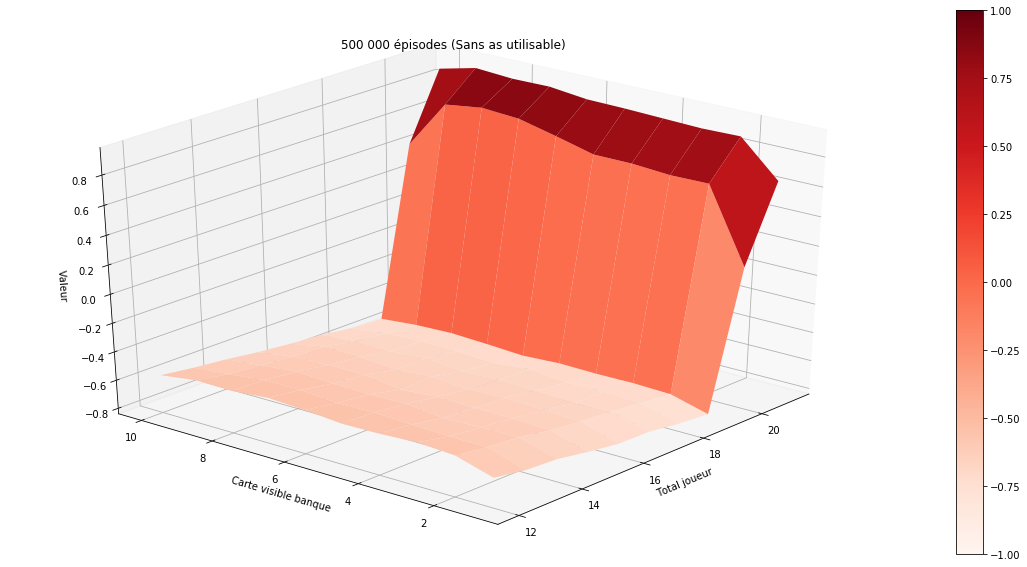

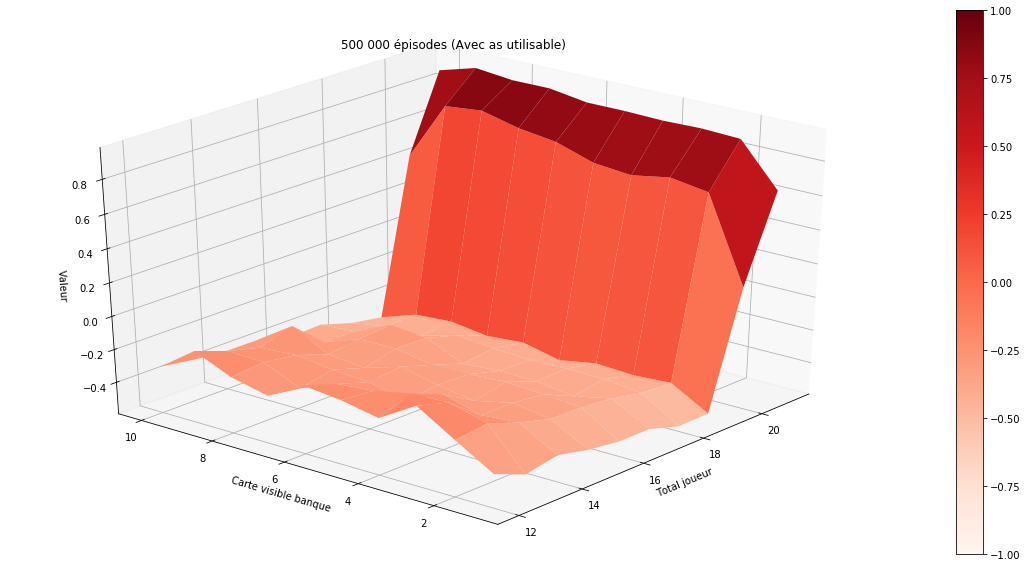

In [1]:
# -*- coding: utf-8 -*-
"""
Prédiction de la fonction valeur avec méthode Monte Carlo première visite
Environnement Blackjack
"""
import gym
from gym import spaces
from gym.utils import seeding
import numpy as np
from collections import defaultdict

def cmp(a, b):
    return int((a > b)) - int((a < b))

# 1 = As, Valet,Dame et Roi = 10
cartes = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10]

def passer_carte(np_random):
    return np_random.choice(cartes)
    
def passer_main(np_random):
    return [passer_carte(np_random), passer_carte(np_random)]

def as_utilisable(main):
    return 1 in main and sum(main) + 10 <= 21

def total_main(main):
    if as_utilisable(main):
            return sum(main) + 10
    return sum(main)

def a_creve(main):
    return total_main(main) > 21

def score(main):  # Retourne le total ou 0 si creve
    return 0 if a_creve(main) else total_main(main)

def blackjack_naturel(main):  # Un as et un dix
    return sorted(main) == [1, 10]

class BlackjackEnv(gym.Env):
    """ Environnement de Blackjack simplifié selon l'exemple 5.1 de Sutton and Barto (2020)
    Reinforcement Learning: An Introduction.
    Le code est basé sur : https://gym.openai.com/envs/Blackjack-v0/
    
    actions possibles : carter (1) ou pas (0)
    etat : 3-tuple(total joueur, la carte visible banque (1-10), as utilisable pour le joueur (vrai ou faux))
    recompense : le joueur gagne (+1), le joueur perd (-1), partie nulle (0)
    """
    def __init__(self, naturel=False,seed=42):
        self.action_space = spaces.Discrete(2)
        self.observation_space = spaces.Tuple((
            spaces.Discrete(32),
            spaces.Discrete(11),
            spaces.Discrete(2)))
        self._seed(seed)

        # Indicateur: paye 1.5 fois pour un naturel 
        self.naturel = naturel

        self._reset()

    def reset(self):
        return self._reset()

    def step(self, action):
        return self._step(action)

    def _seed(self, seed=42):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]


    def _step(self, action):
        assert self.action_space.contains(action)
        if action:  # carter
            self.joueur.append(passer_carte(self.np_random))
            if a_creve(self.joueur):
                final = True
                recompense = -1
            else:
                final = False
                recompense = 0
        else:  # arrêter
            final = True
            while total_main(self.banque) < 17:
                self.banque.append(passer_carte(self.np_random))
            recompense = cmp(score(self.joueur), score(self.banque))
            if self.naturel and blackjack_naturel(self.joueur) and recompense == 1:
                recompense = 1.5
        return self._get_obs(), recompense, final, {}

    def _get_obs(self):
        return (total_main(self.joueur), self.banque[0], as_utilisable(self.joueur))

    def _reset(self):
        self.banque = passer_main(self.np_random)
        self.joueur = passer_main(self.np_random)

        # Carter si total inférieur à 12
        while total_main(self.joueur) < 12:
            self.joueur.append(passer_carte(self.np_random))
        
        return self._get_obs()

import matplotlib
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 

def afficher_V(V, titre="Fonction valeur de la politique selon méthode de Monte Carlo première visite"):
    """
    Afficher V comme surface en 3D
    
    V : dictionnaire (etat, valeur)
    """
    # Déterminer les quadrillages des axes X et Y
    min_x = min(etat[0] for etat in V.keys()) # axe des x : main du joueur
    max_x = max(etat[0] for etat in V.keys())
    min_y = min(etat[1] for etat in V.keys()) # axe des y : main de la banque
    max_y = max(etat[1] for etat in V.keys())

    x_range = np.arange(min_x, max_x + 1)
    y_range = np.arange(min_y, max_y + 1)
    X, Y = np.meshgrid(x_range, y_range)

    # Rassembler les valeurs de z pour tous les (x, y) : distinguer les cas avec et sans as utilisable
    Z_sans_as = np.apply_along_axis(lambda _: V[(_[0], _[1], False)], 2, np.dstack([X, Y]))
    Z_as = np.apply_along_axis(lambda _: V[(_[0], _[1], True)], 2, np.dstack([X, Y]))

    def afficher_surface(X, Y, Z, titre):
        fig = plt.figure(figsize=(20, 10))
        ax = fig.add_subplot(111, projection='3d')
        surface = ax.plot_surface(X, Y, Z, rstride=1, cstride=1,
                               cmap=matplotlib.cm.Reds, vmin=-1.0, vmax=1.0)
        ax.set_xlabel('Total joueur')
        ax.set_ylabel('Carte visible banque')
        ax.set_zlabel('Valeur')
        ax.set_title(titre)
        ax.view_init(ax.elev, -140)
        fig.colorbar(surface)
        plt.show()

    afficher_surface(X, Y, Z_sans_as, "{} (Sans as utilisable)".format(titre))
    afficher_surface(X, Y, Z_as, "{} (Avec as utilisable)".format(titre))

env = BlackjackEnv()

def predire_valeurpi_mc(politique, env, nombre_episodes, gamma=1.0):
    """
    Prédire la valeur de la politique par la métode de Monte Carlo première visite
    Monte Carlo prediction algorithm. Calculates the value function

        politique: fonction pi
        env: environnement de type OpenAI gym
        nombre_episodes: nombre d'épisodes générés pour les estimations
        gamma: facteur d'escompte des récompenses futures
    
    Retour:
        V: Dictionnaire(etat,valeur)
        The etat is a tuple and the value is a float.
    """

    V = defaultdict(float) # Valeur moyenne de récompense pour chacun des états
    liste_G = defaultdict(list) # Liste des retours observés pour chacun des états
    
    for i_episode in range(1, nombre_episodes + 1):
        # Print out which episode we're on, useful for debugging.
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, nombre_episodes), end="")

         # Un episode est un tableau de tules (etat, action, recompense)
        episode = []
        etat = env.reset()
        for t in range(100):
            action = politique(etat)
            etat_suivant, recompense, final, _ = env.step(action)
            episode.append((etat, action, recompense))
            if final:
                break
            etat = etat_suivant
            
        etats_episode = [etape[0] for etape in episode]
        G=0
        for t in range(len(episode)-1,-1,-1):
            G=gamma*G+episode[t][2]
            St = episode[t][0]
            if St not in etats_episode[0:t]:
                liste_G[St].append(G)
                V[St]=np.mean(liste_G[St])
    return V


def politique_reste_20ou21(observation):
    """
    Politique simple : le joueur reste à 20 ou 21, carte sinon
    """
    return 0 if observation[0] >= 20 else 1

V_10000 = predire_valeurpi_mc(politique_reste_20ou21, env, nombre_episodes=10000)
afficher_V(V_10000, titre="10 000 épisodes")

V_500000 = predire_valeurpi_mc(politique_reste_20ou21, env, nombre_episodes=500000)
afficher_V(V_500000, titre="500 000 épisodes")
